In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geographiclib.geodesic import Geodesic
import math
from cmdstanpy import CmdStanModel, set_cmdstan_path
import os
import arviz as az

GEOLOCATION="FRI"
KNOWN_POINTS_CSV = f'{GEOLOCATION}/known_points.csv'
REF_POINTS_CSV = f'{GEOLOCATION}/points.csv'
CMDSTAN_PATH = "/home/klemen/micromamba/envs/gps/bin/cmdstan"
STAN_MODEL_PATH = 'newmodel.stan'
FIGURES_PATH = 'figs'

selected_comparison = "P2vsP3" # P1vsP2, P1vsP3, P2vsP3


set_cmdstan_path(CMDSTAN_PATH)

# Quick sanity check
assert KNOWN_POINTS_CSV != REF_POINTS_CSV
assert KNOWN_POINTS_CSV.split('/')[0] == REF_POINTS_CSV.split('/')[0] # Ensure the data is from the same area

def read_known_points(known_csv):
    df = pd.read_csv(known_csv)
    print(f"Read {len(df)} known points from {known_csv}")
    assert len(df) == np.unique(df['name']).shape[0]
    return df

# Our goal is to assist the investigation by providing a relative quantification of whether the the device was at the proposed points P1, P2... when it took the evidence E due to GPS error.
known_points_df = read_known_points(KNOWN_POINTS_CSV)
known_points_df

/home/klemen/micromamba/envs/gps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read 4 known points from FRI/known_points.csv


,name,lat,lng
0,P1,46.050717,14.469448
1,P2,46.050919,14.468425
2,P3,46.050141,14.468594
3,E,46.050578,14.468767


In [2]:
def lat_lng2dist_ang(center_point_lat_lng, target_point_lat_lng):
    # center_point_lat_lng = [lat, lng] this is one of the known proposal points (not the evidence point)
    # target_point_lat_lng = [lat, lng] this is one of the measured points for the proposal, can also be the evidence point
    # computes distance (in meters) between two points and azimuth (angle from north in radians) of the line using WGS84 ellipsoid, line spins around center_point_lat_lng
    # computes angle (in radians and degrees) between two points
    results = Geodesic.WGS84.Inverse(center_point_lat_lng[0], center_point_lat_lng[1], target_point_lat_lng[0], target_point_lat_lng[1])
    distance = results['s12']
    angle_deg = results['azi1']
    angle = math.radians(angle_deg)
    return distance, angle, angle_deg

def prepare_measurements_for_proposal(ref_csv, proposal_name, known_points_df):
    proposal_lat_lng = known_points_df[known_points_df['name'] == proposal_name][['lat', 'lng']].values[0].tolist()
    print(f"Proposal {proposal_name} lat, lng: {proposal_lat_lng}")
    df = pd.read_csv(ref_csv)
    needed_columns = ['datetime', 'measured_from', 'lat', 'lng', 'precise']
    df = df[needed_columns]
    df = df[df['measured_from'] == proposal_name]
    df = df[df['precise'] == 'on']
    df = df.drop(columns=['precise'])
    df = df.sort_values(by='datetime', ascending=True, ignore_index=True)
    # flag indicating if two consecutive (by datetime) measurements  are the same (lat, lng)
    df['same_as_prev'] = df[['lat', 'lng']].duplicated(keep='first')
    num_rows = df.shape[0]
    num_duplicates = df['same_as_prev'].sum()
    print(f"Number of measurements for proposal {proposal_name}: {num_rows}")
    print(f"Number of duplicate consecutive measurements: {num_duplicates} ({num_duplicates/num_rows*100:.2f}%)")
    # remove duplicate consecutive measurements
    df = df[df['same_as_prev'] == False]
    df = df.drop(columns=['same_as_prev'])
    df = df.reset_index(drop=True)
    
    df["dist"] = df.apply(lambda x: lat_lng2dist_ang(proposal_lat_lng, [x["lat"], x["lng"]])[0], axis=1)
    df["angle"] = df.apply(lambda x: lat_lng2dist_ang(proposal_lat_lng, [x["lat"], x["lng"]])[1], axis=1)
    df["angle_deg"] = df.apply(lambda x: lat_lng2dist_ang(proposal_lat_lng, [x["lat"], x["lng"]])[2], axis=1)

    print(f"Clean measurements for proposal {proposal_name}: {df.shape[0]}")
    display(df)
    display(df.describe())
    return df

p1_measurements = prepare_measurements_for_proposal(REF_POINTS_CSV, 'P1', known_points_df)
p2_measurements = prepare_measurements_for_proposal(REF_POINTS_CSV, 'P2', known_points_df)
p3_measurements = prepare_measurements_for_proposal(REF_POINTS_CSV, 'P3', known_points_df)
E_wrt_P1 = lat_lng2dist_ang(known_points_df[known_points_df['name'] == 'P1'][['lat', 'lng']].values[0].tolist(), known_points_df[known_points_df['name'] == 'E'][['lat', 'lng']].values[0].tolist())
E_wrt_P1 = [E_wrt_P1[0], E_wrt_P1[1]]
E_wrt_P2 = lat_lng2dist_ang(known_points_df[known_points_df['name'] == 'P2'][['lat', 'lng']].values[0].tolist(), known_points_df[known_points_df['name'] == 'E'][['lat', 'lng']].values[0].tolist())
E_wrt_P2 = [E_wrt_P2[0], E_wrt_P2[1]]
E_wrt_P3 = lat_lng2dist_ang(known_points_df[known_points_df['name'] == 'P3'][['lat', 'lng']].values[0].tolist(), known_points_df[known_points_df['name'] == 'E'][['lat', 'lng']].values[0].tolist())
E_wrt_P3 = [E_wrt_P3[0], E_wrt_P3[1]]
print(f"E_wrt_P1: {E_wrt_P1}")
print(f"E_wrt_P2: {E_wrt_P2}")
print(f"E_wrt_P3: {E_wrt_P3}")

# save cleaned data
p1_measurements.to_csv(f'{GEOLOCATION}/p1_clean_measurements.csv', index=False)
p2_measurements.to_csv(f'{GEOLOCATION}/p2_clean_measurements.csv', index=False)
p3_measurements.to_csv(f'{GEOLOCATION}/p3_clean_measurements.csv', index=False)

Proposal P1 lat, lng: [46.05071708333333, 14.469447750000002]
Number of measurements for proposal P1: 100
Number of duplicate consecutive measurements: 91 (91.00%)
Clean measurements for proposal P1: 9


,datetime,measured_from,lat,lng,dist,angle,angle_deg
0,2024:04:02 14:19:42,P1,46.050728,14.469481,2.803403,1.132911,64.911039
1,2024:04:02 14:19:43,P1,46.050719,14.469464,1.276303,1.363691,78.133761
2,2024:04:02 14:19:43,P1,46.050725,14.469472,2.088404,1.135859,65.079935
3,2024:04:02 14:19:44,P1,46.050714,14.469461,1.093313,1.901560,108.951337
4,2024:04:02 14:19:45,P1,46.050706,14.469458,1.520759,2.572826,147.412055
5,2024:04:02 14:19:47,P1,46.050700,14.469453,1.938310,2.939471,168.419283
6,2024:04:02 14:20:09,P1,46.050731,14.469450,1.507559,0.115765,6.632847
7,2024:04:02 14:20:24,P1,46.050728,14.469436,1.491446,-0.648451,-37.153511
8,2024:04:02 14:20:29,P1,46.050725,14.469436,1.259244,-0.797082,-45.669437


,lat,lng,dist,angle,angle_deg
count,9.000000,9.000000,9.000000,9.000000,9.000000
mean,46.050719,14.469457,1.664304,1.079617,61.857479
std,0.000011,0.000015,0.532469,1.317585,75.492081
min,46.050700,14.469436,1.093313,-0.797082,-45.669437
25%,46.050714,14.469450,1.276303,0.115765,6.632847
50%,46.050725,14.469458,1.507559,1.135859,65.079935
75%,46.050728,14.469464,1.938310,1.901560,108.951337
max,46.050731,14.469481,2.803403,2.939471,168.419283


Proposal P2 lat, lng: [46.05091916666666, 14.46842538888889]
Number of measurements for proposal P2: 100
Number of duplicate consecutive measurements: 72 (72.00%)
Clean measurements for proposal P2: 28


,datetime,measured_from,lat,lng,dist,angle,angle_deg
0,2024:04:02 14:16:18,P2,46.050925,14.468444,1.610993,1.156575,66.266846
1,2024:04:02 14:16:20,P2,46.050925,14.468442,1.416840,1.095468,62.765716
2,2024:04:02 14:16:35,P2,46.050931,14.468436,1.513638,0.580242,33.245410
3,2024:04:02 14:16:36,P2,46.050931,14.468444,1.943553,0.861456,49.357767
4,2024:04:02 14:16:38,P2,46.050925,14.468453,2.216637,1.273946,72.991703
5,2024:04:02 14:16:39,P2,46.050922,14.468447,1.723525,1.372441,78.635097
6,2024:04:02 14:16:40,P2,46.050922,14.468453,2.146723,1.411919,80.897005
7,2024:04:02 14:16:42,P2,46.050925,14.468450,2.012044,1.242687,71.200721
8,2024:04:02 14:16:44,P2,46.050925,14.468439,1.229636,1.015375,58.176699
9,2024:04:02 14:16:45,P2,46.050919,14.468436,0.830391,1.533606,87.869129


,lat,lng,dist,angle,angle_deg
count,28.000000,28.000000,28.000000,28.000000,28.000000
mean,46.050913,14.468412,2.607040,-0.448528,-25.698772
std,0.000009,0.000032,1.265755,1.856444,106.366383
min,46.050903,14.468364,0.830391,-2.940809,-168.495966
25%,46.050907,14.468381,1.489439,-2.013336,-115.355666
50%,46.050911,14.468417,2.181680,-1.775195,-101.711209
75%,46.050923,14.468442,3.734289,1.250502,71.648466
max,46.050931,14.468453,5.096318,2.820981,161.630318


Proposal P3 lat, lng: [46.05014119444444, 14.468594055555556]
Number of measurements for proposal P3: 100
Number of duplicate consecutive measurements: 93 (93.00%)
Clean measurements for proposal P3: 7


,datetime,measured_from,lat,lng,dist,angle,angle_deg
0,2024:04:02 14:22:53,P3,46.050122,14.468603,2.214214,2.831793,162.249812
1,2024:04:02 14:22:55,P3,46.050125,14.468603,1.922462,2.782811,159.443310
2,2024:04:02 14:22:55,P3,46.050125,14.468600,1.857911,2.891367,165.663143
3,2024:04:02 14:23:00,P3,46.050142,14.468592,0.192190,-1.294175,-74.150749
4,2024:04:02 14:23:01,P3,46.050144,14.468592,0.405808,-0.473040,-27.103216
5,2024:04:02 14:23:46,P3,46.050125,14.468619,2.664794,2.312429,132.492429
6,2024:04:02 14:24:43,P3,46.050142,14.468611,1.321029,1.531053,87.722855


,lat,lng,dist,angle,angle_deg
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,46.050132,14.468603,1.511201,1.511748,86.616798
std,0.000010,0.000010,0.923056,1.718309,98.451867
min,46.050122,14.468592,0.192190,-1.294175,-74.150749
25%,46.050125,14.468596,0.863418,0.529006,30.309819
50%,46.050125,14.468603,1.857911,2.312429,132.492429
75%,46.050142,14.468607,2.068338,2.807302,160.846561
max,46.050144,14.468619,2.664794,2.891367,165.663143


E_wrt_P1: [54.93803082601422, -1.8565109379315445]
E_wrt_P2: [46.233344548462505, 2.533522319111691]
E_wrt_P3: [50.33242726496936, 0.2686313816489416]


Text(14.468766666666667, 46.050577777777775, 'E')

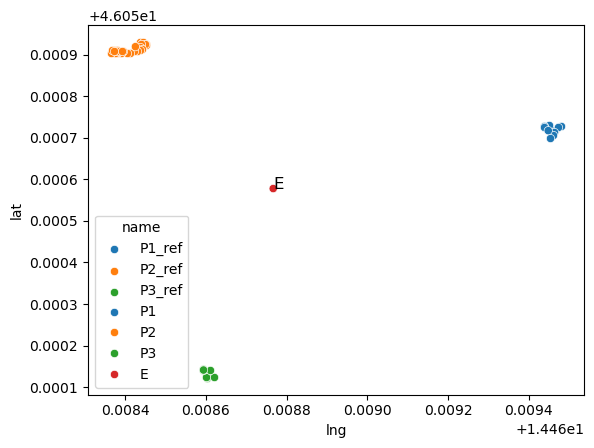

In [3]:
# visualize points on the map
fig, ax = plt.subplots()
sns.scatterplot(x='lng', y='lat', data=p1_measurements, ax=ax, label='P1_ref')
sns.scatterplot(x='lng', y='lat', data=p2_measurements, ax=ax, label='P2_ref')
sns.scatterplot(x='lng', y='lat', data=p3_measurements, ax=ax, label='P3_ref')
sns.scatterplot(x='lng', y='lat', data=known_points_df, ax=ax, hue='name')
ax.text(known_points_df[known_points_df['name'] == 'E']['lng'].values[0], known_points_df[known_points_df['name'] == 'E']['lat'].values[0], 'E', fontsize=12)

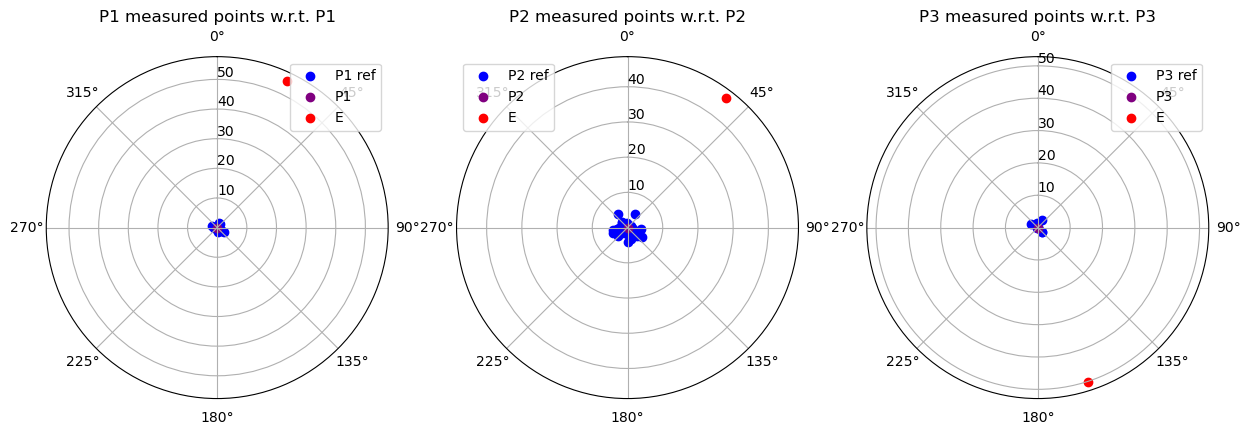

In [4]:
def visualize_polar(proposal_measurements, ax, known_points_df):
    # meters and degrees
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    ax.set_title(f"{proposal_measurements['measured_from'][0]} measured points w.r.t. {proposal_measurements['measured_from'][0]}")
    ax.scatter(proposal_measurements["angle_deg"], proposal_measurements["dist"], label=f"{proposal_measurements['measured_from'][0]} ref", color="blue")
    ax.scatter(0, 0, label=proposal_measurements['measured_from'][0], color="purple")
    ax.set_rmax(max(proposal_measurements["dist"]))
    # E lat lng to float
    E_lat_lng = known_points_df[known_points_df['name'] == 'E'][['lat', 'lng']].values[0].tolist()
    P_lat_lng = known_points_df[known_points_df['name'] == proposal_measurements['measured_from'][0]][['lat', 'lng']].values[0].tolist()
    E_dist, _, E_angle_deg = lat_lng2dist_ang(P_lat_lng, E_lat_lng)
    ax.scatter(E_angle_deg, E_dist, label='E', color='red')
    ax.legend()
    return ax

fig, ax = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(15,7))
for ax1, proposal_measurements in zip(ax.flatten(), [p1_measurements, p2_measurements, p3_measurements]):
    visualize_polar(proposal_measurements, ax1, known_points_df)

fig.savefig(f'{FIGURES_PATH}/{GEOLOCATION}_polar.pdf')



Here we empirically confirm that the GPS error is very dependent on the (lat, lng) location too.

In [5]:
runs = {
    "P1vsP2": [p1_measurements, p2_measurements, p1_measurements.loc[:, ["dist", "angle"]].values, p2_measurements.loc[:, ["dist", "angle"]].values, E_wrt_P1, E_wrt_P2],
    "P1vsP3": [p1_measurements, p3_measurements, p1_measurements.loc[:, ["dist", "angle"]].values, p3_measurements.loc[:, ["dist", "angle"]].values, E_wrt_P1, E_wrt_P3],
    "P2vsP3": [p2_measurements, p3_measurements, p2_measurements.loc[:, ["dist", "angle"]].values, p3_measurements.loc[:, ["dist", "angle"]].values, E_wrt_P2, E_wrt_P3]
}


stan_data = {
    "N_A": runs[selected_comparison][0].shape[0],
    "N_B": runs[selected_comparison][1].shape[0],
    "A": runs[selected_comparison][2],
    "B": runs[selected_comparison][3],
    "E_A": runs[selected_comparison][4],
    "E_B": runs[selected_comparison][5]
}
stan_data

{'N_A': 28,
 'N_B': 7,
 'A': array([[ 1.61099337,  1.15657465],
        [ 1.41684016,  1.0954684 ],
        [ 1.51363849,  0.58024186],
        [ 1.94355293,  0.86145555],
        [ 2.21663681,  1.27394554],
        [ 1.72352461,  1.37244135],
        [ 2.14672338,  1.41191909],
        [ 2.01204399,  1.24268701],
        [ 1.22963564,  1.01537494],
        [ 0.83039069,  1.53360562],
        [ 1.38966612,  2.00660372],
        [ 1.22078878,  2.3941872 ],
        [ 1.26880464,  2.82098123],
        [ 1.22883656, -2.94080939],
        [ 2.1306    , -2.596347  ],
        [ 2.38212389, -2.44140623],
        [ 2.68054622, -2.03668618],
        [ 3.361256  , -2.14356247],
        [ 3.91888121, -2.05425287],
        [ 4.11043657, -2.0299389 ],
        [ 4.30420481, -2.00780195],
        [ 5.09631773, -1.93632868],
        [ 4.21098234, -1.78506474],
        [ 4.63200921, -1.76532621],
        [ 3.58342045, -1.8233433 ],
        [ 3.67275787, -1.90483342],
        [ 4.28726261, -1.85549322],


In [6]:
stan_model = CmdStanModel(stan_file=STAN_MODEL_PATH)
fit = stan_model.sample(data=stan_data,
                        chains=4,
                        iter_warmup=1000,
                        iter_sampling=4000,
                        seed=1,
                        adapt_delta=0.96,
                        max_treedepth=12,
                        parallel_chains=os.cpu_count())
display(fit.summary())
print(fit.diagnose())

22:24:08 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
22:24:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Iteration:    1 / 5000 [  0%]  (Warmup)


chain 1 |▌         | 00:01 Iteration:  100 / 5000 [  2%]  (Warmup)


chain 1 |▊         | 00:01 Iteration:  200 / 5000 [  4%]  (Warmup)


chain 1 |▉         | 00:02 Iteration:  300 / 5000 [  6%]  (Warmup)


chain 1 |█▎        | 00:03 Iteration:  500 / 5000 [ 10%]  (Warmup)


chain 1 |█▌        | 00:04 Iteration:  600 / 5000 [ 12%]  (Warmup)



chain 1 |█▋        | 00:05 Iteration:  700 / 5000 [ 14%]  (Warmup)


chain 1 |█▉        | 00:05 Iteration:  800 / 5000 [ 16%]  (Warmup)


chain 1 |██        | 00:06 Iteration:  900 / 5000 [ 18%]  (Warmup)


chain 1 |██▌       | 00:06 Iteration: 1001 / 5000 [ 20%]  (Sampling)

chain 1 |██▋       | 00:07 Iteration: 1100 / 5000 [ 22%]  (Sampling)


chain 1 |██▉       | 00:07 Itera


22:24:42 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-5.223870e+01,0.092407,3.663840,-59.025200,-51.651100,-4.738700e+01,1572.03000,18.79610,1.00353
mu_A[1],2.607310e+00,0.002754,0.262719,2.171540,2.607730,3.041370e+00,9103.52000,108.84700,1.00016
mu_A[2],-4.501650e-01,0.004171,0.385020,-1.087040,-0.452006,1.784970e-01,8521.01000,101.88200,1.00036
mu_B[1],1.524260e+00,0.010865,0.901371,0.398562,1.518270,2.632900e+00,6882.77000,82.29430,1.00058
mu_B[2],1.523500e+00,0.016403,1.478810,-0.568885,1.533200,3.648910e+00,8128.22000,97.18570,1.00044
"L_A[1,1]",1.671970e-02,0.017813,0.996693,-1.423460,0.029051,1.436840e+00,3130.74000,37.43290,1.00254
"L_A[1,2]",6.940300e-03,0.017722,0.987537,-1.416650,0.013328,1.420080e+00,3105.21000,37.12760,1.00097
"L_A[2,1]",-1.357940e-02,0.026197,1.460270,-2.123150,0.000666,2.085860e+00,3107.27000,37.15230,1.00265
"L_A[2,2]",-1.777080e-02,0.025836,1.452060,-2.084900,-0.035110,2.084640e+00,3158.89000,37.76960,1.00081
"L_B[1,1]",-2.210690e-02,0.021427,1.675280,-2.157040,-0.037938,2.077110e+00,6112.73000,73.08740,1.00012


Processing csv files: /tmp/tmp0gyl_8w2/newmodelgq9t81t3/newmodel-20240801222408_1.csv, /tmp/tmp0gyl_8w2/newmodelgq9t81t3/newmodel-20240801222408_2.csv, /tmp/tmp0gyl_8w2/newmodelgq9t81t3/newmodel-20240801222408_3.csv, /tmp/tmp0gyl_8w2/newmodelgq9t81t3/newmodel-20240801222408_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



array([[<Axes: title={'center': 'L_A\n0, 0'}>,
        <Axes: title={'center': 'L_A\n0, 0'}>],
       [<Axes: title={'center': 'L_A\n0, 1'}>,
        <Axes: title={'center': 'L_A\n0, 1'}>],
       [<Axes: title={'center': 'L_A\n1, 0'}>,
        <Axes: title={'center': 'L_A\n1, 0'}>],
       [<Axes: title={'center': 'L_A\n1, 1'}>,
        <Axes: title={'center': 'L_A\n1, 1'}>],
       [<Axes: title={'center': 'L_B\n0, 0'}>,
        <Axes: title={'center': 'L_B\n0, 0'}>],
       [<Axes: title={'center': 'L_B\n0, 1'}>,
        <Axes: title={'center': 'L_B\n0, 1'}>],
       [<Axes: title={'center': 'L_B\n1, 0'}>,
        <Axes: title={'center': 'L_B\n1, 0'}>],
       [<Axes: title={'center': 'L_B\n1, 1'}>,
        <Axes: title={'center': 'L_B\n1, 1'}>],
       [<Axes: title={'center': 'log_lik_A'}>,
        <Axes: title={'center': 'log_lik_A'}>],
       [<Axes: title={'center': 'log_lik_B'}>,
        <Axes: title={'center': 'log_lik_B'}>],
       [<Axes: title={'center': 'log_likelihood_ra

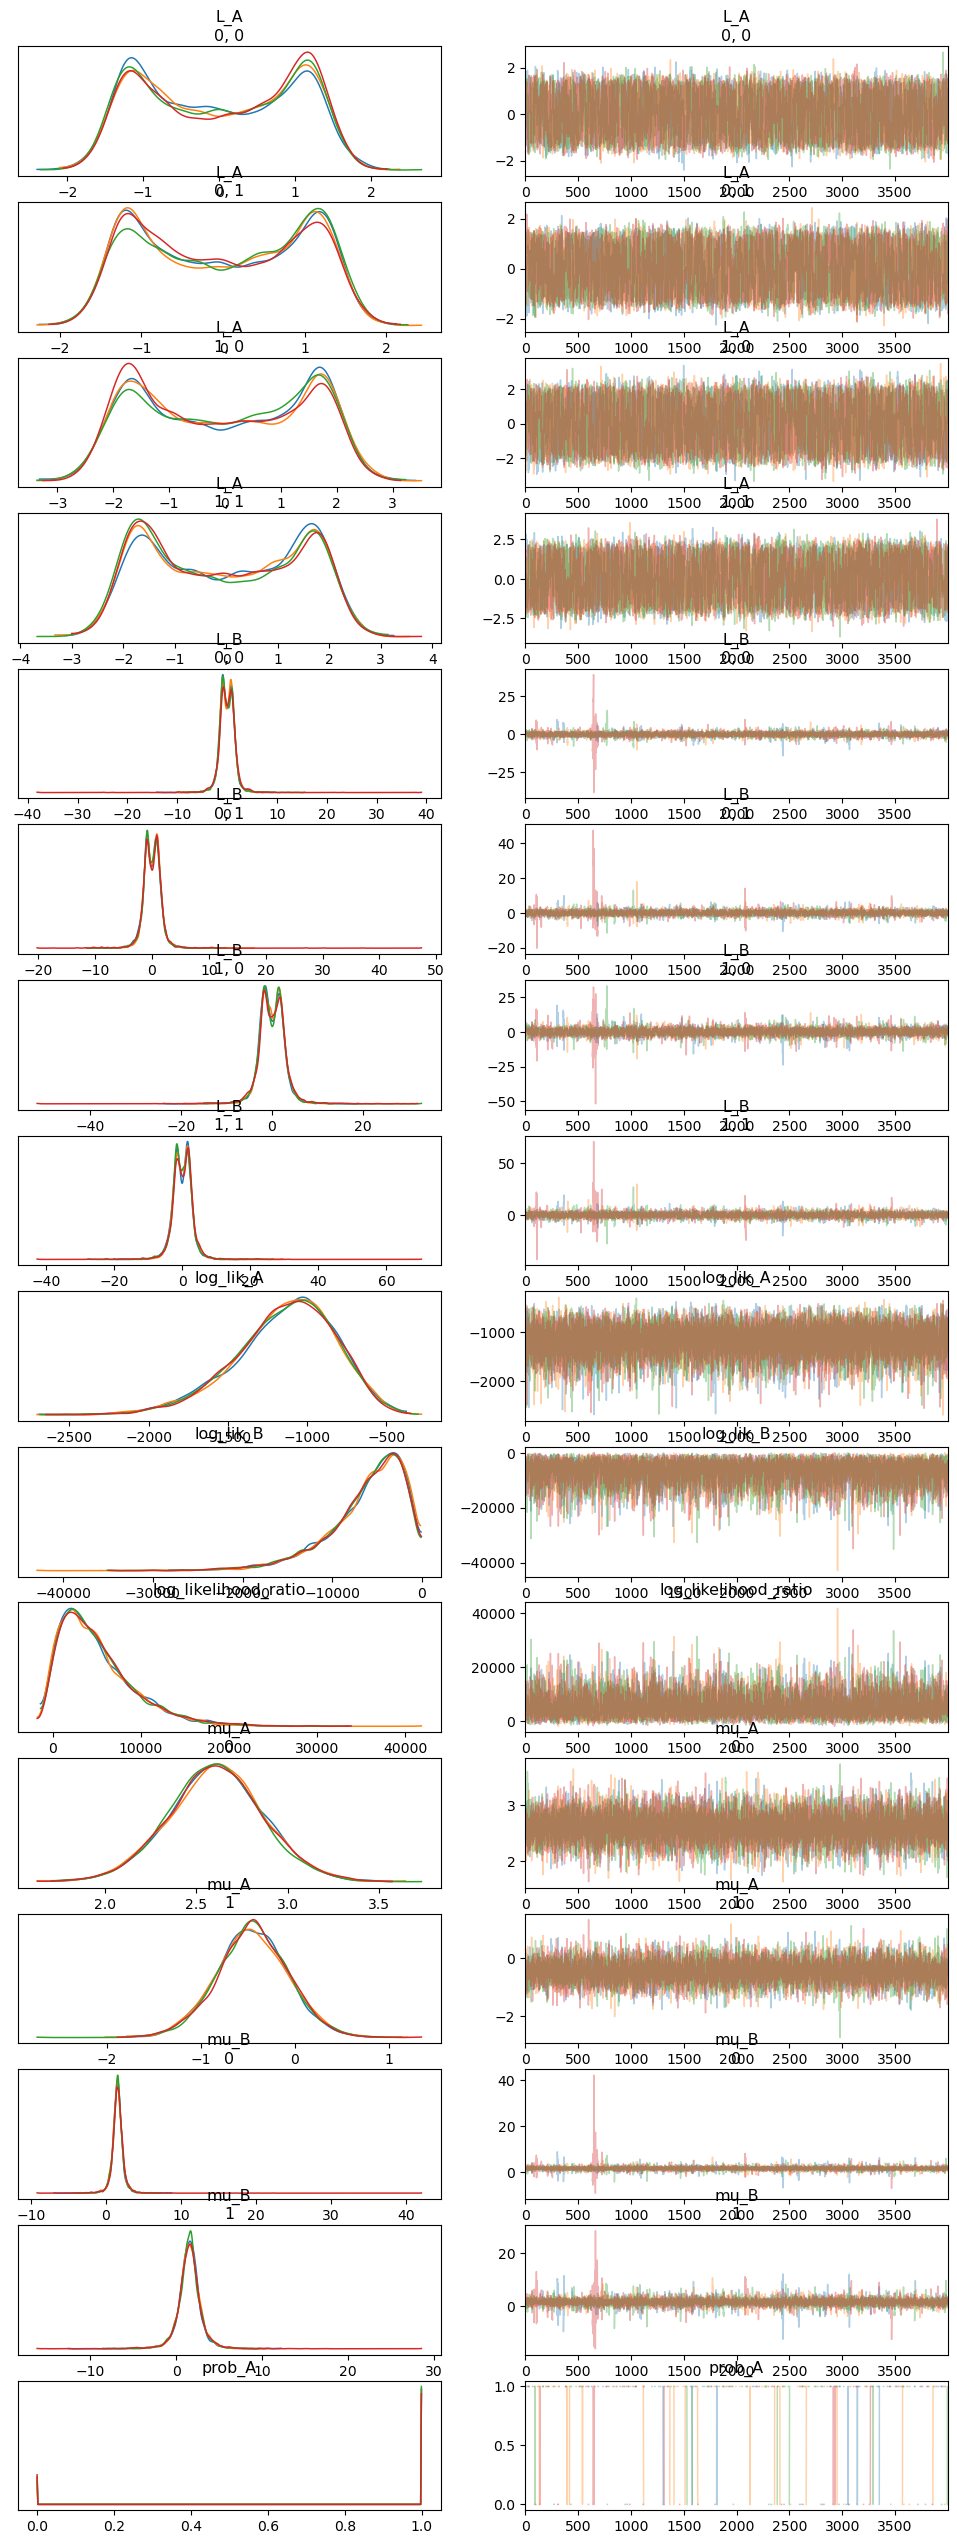

In [7]:
# traceplots
# az.plot_trace(fit, compact=False)
az.plot_trace(fit, compact=False, var_names="~likelihood_ratio") # in case its unstable

In [8]:
draws_df = fit.draws_pd()
draws_df = draws_df[['log_likelihood_ratio', 'likelihood_ratio', 'prob_A']]
draws_df = abs(draws_df) # sign does not matter for ratios in our case, prob_A is always positive
draws_df.to_csv(f'{GEOLOCATION}/{selected_comparison}_draws.csv', index=False)


print(f"Summary for {selected_comparison}")
# log likelihood ratio median + hdi
log_likelihood_ratio_median = np.round(draws_df['log_likelihood_ratio'].median(), 4)
log_likelihood_ratio_hdi = np.round(az.hdi(draws_df['log_likelihood_ratio'].values, hdi_prob=0.95), 4)
print(f"log_likelihood_ratio_median: {log_likelihood_ratio_median}, 95% HDI: {log_likelihood_ratio_hdi}")

# likelihood ratio median + hdi
likelihood_ratio_median = np.round(draws_df['likelihood_ratio'].median(), 4)
likelihood_ratio_hdi = np.round(az.hdi(draws_df['likelihood_ratio'].values, hdi_prob=0.95), 4)
print(f"likelihood_ratio_median: {likelihood_ratio_median}, 95% HDI: {likelihood_ratio_hdi}")

# skip if there are NaNs (under/overflow)
if not np.isnan(draws_df['prob_A']).any:
    prob_A, prob_A_mcse = np.round(draws_df['prob_A'].mean(), 4), np.round(az.mcse(draws_df['prob_A'].values), 4)
    print(f"prob_A: {prob_A} +- {prob_A_mcse}") # probability that the device was at point A when it took the evidence E



Summary for P2vsP3
log_likelihood_ratio_median: 4066.165, 95% HDI: [8.11000e-02 1.33803e+04]
likelihood_ratio_median: inf, 95% HDI: [ 0. inf]
